In [227]:
import pandas as pd                                                                                             
import pandas_datareader.data as web                                          
from datetime import datetime                                                   
ticker_names=['tsy2','btc','rsv','sp500','dollar']                                                                                                                   
tickers = ['DFF','CBBTCUSD','WRESBAL','SP500','DTWEXEMEGS']
start_date = '2021-01-01' 
end_date = datetime.now().strftime('%Y-%m-%d')                                                                                                                             

In [228]:
df = web.DataReader(tickers, 'fred', start_date, end_date)                                       
df.columns = ticker_names
dfw=df.dropna()
dfw.to_csv('data/fred.csv')

In [231]:
dfw=pd.read_csv('data/fred.csv', parse_dates=['DATE']).set_index('DATE')

dfm=dfw.resample('M').last()

In [232]:
df_stables = pd.read_csv('data/marketcap.csv', parse_dates=['ds'])
dfss = df_stables.groupby('ds')['market_cap'].sum()/1e9

In [233]:
dfmerged=pd.merge(dfm,dfss,left_index=True,right_index=True)

In [234]:
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from stargazer.stargazer import Stargazer

In [249]:
data=dfmerged.copy()

# del data['tsy2']
# Calculate log returns for price data
price_columns = ['btc', 'rsv', 'sp500','market_cap','dollar']
log_returns = np.log(data[price_columns] / data[price_columns].shift(1)).dropna()

# combined_data=log_returns.copy()
# Calculate first differences for yield data
yield_column = 'tsy2'
yield_diff = data[yield_column].diff().dropna()

# Combine the log returns and yield differences into a single DataFrame
combined_data = pd.concat([yield_diff, log_returns], axis=1).dropna()

KeyError: 'tsy2'

In [276]:
data=dfmerged.copy()

del data['dollar']
# Calculate log returns for price data
price_columns = ['btc', 'rsv', 'sp500','market_cap']
log_returns = np.log(data[price_columns] / data[price_columns].shift(1)).dropna()

# combined_data=log_returns.copy()
# Calculate first differences for yield data
yield_column = 'tsy2'
yield_diff = data[yield_column].diff().dropna()

# Combine the log returns and yield differences into a single DataFrame
combined_data = pd.concat([yield_diff, log_returns], axis=1).dropna()

data=dfmerged.copy()
del data['tsy2']
combined_data=log_returns.copy()


# log_returns = np.log(combined_data / combined_data.shift(1)).dropna()

In [290]:
# Fit the VAR model
model = VAR(combined_data)

lag_order = model.select_order(maxlags=6).aic
lag_order=1
print(lag_order)
model_fitted = model.fit(lag_order)

1


/Users/gordonliao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


print(model_fitted.summary())


In [291]:
# Step 4: Model Validation
# # Check residuals
# residuals = model_fitted.resid
# print(sm.stats.acorr_ljungbox(residuals, lags=[6], return_df=True))


# Get the residuals from the fitted model
residuals = model_fitted.resid

# Calculate the standard deviation of the residuals
std_residuals = residuals.std()
print("Standard Deviations of Residuals:")
print(std_residuals)

Standard Deviations of Residuals:
tsy2          0.223565
btc           0.169303
rsv           0.046526
sp500         0.042767
market_cap    0.039474
dtype: float64


In [292]:

# Calculate the standard deviations of the explanatory variables (log returns)
std_explanatory = combined_data.std()
print("Standard Deviations of Explanatory Variables:")
print(std_explanatory)

Standard Deviations of Explanatory Variables:
tsy2          0.242339
btc           0.192635
rsv           0.052684
sp500         0.045407
market_cap    0.080724
dtype: float64


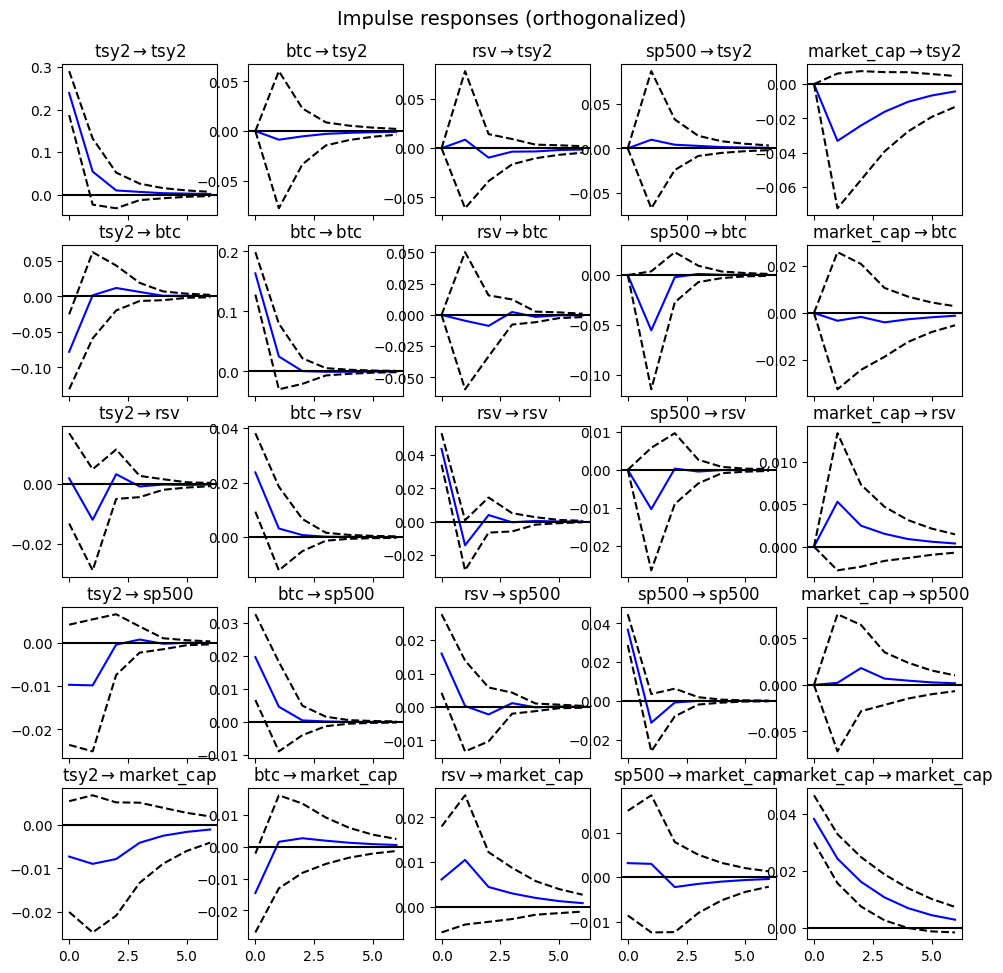

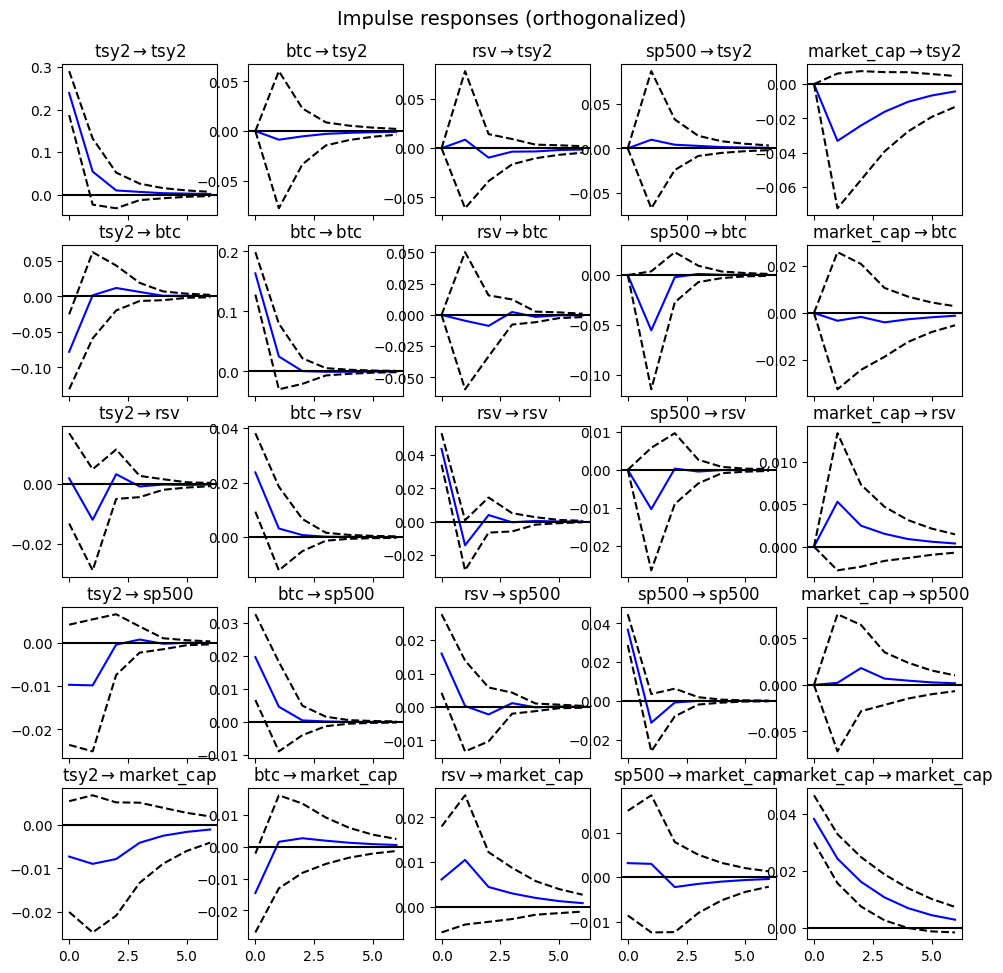

In [293]:
# Impulse Response Functions
irf = model_fitted.irf(6)
irf.plot(orth=True)

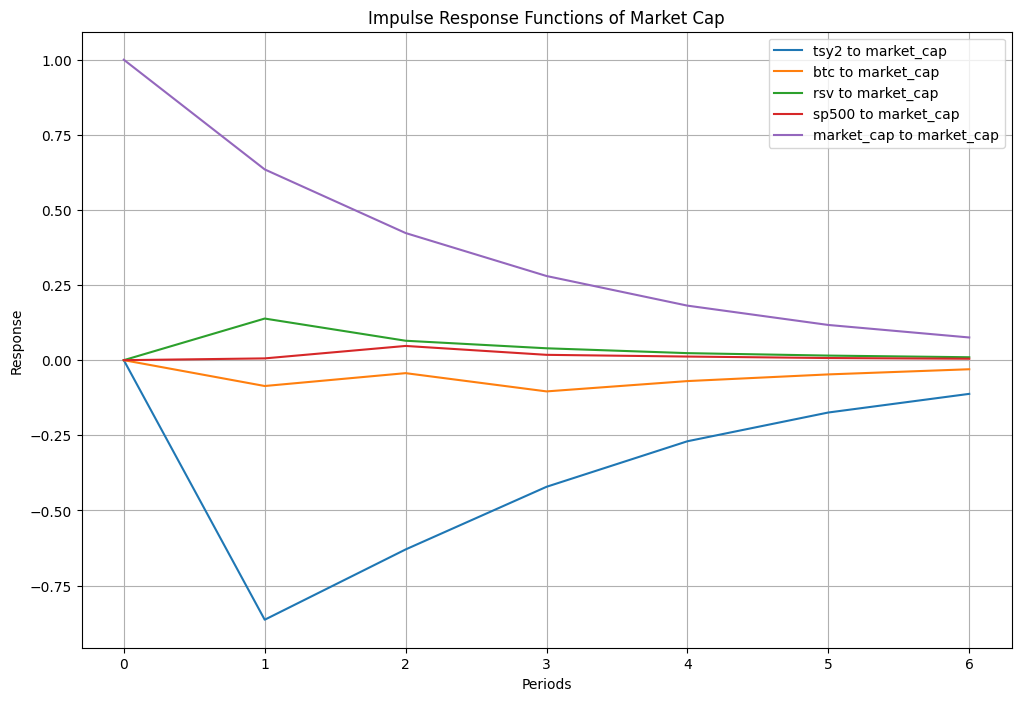

In [294]:
import matplotlib.pyplot as plt

# Assuming `model_fitted` is your fitted VAR model
irf = model_fitted.irf(6)

# Extract IRFs for the 'market_cap' variable only
irf_market_cap = irf.irfs[:, :, model_fitted.names.index('market_cap')]

# Plot the IRFs
plt.figure(figsize=(12, 8))

for i, var in enumerate(model_fitted.names):
    plt.plot(irf_market_cap[:, i], label=f'{var} to market_cap')

plt.title('Impulse Response Functions of Market Cap')
plt.xlabel('Periods')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()
# # Forecast Error Variance Decomposition
# fevd = model_fitted.fevd(10)
# fevd.plot()

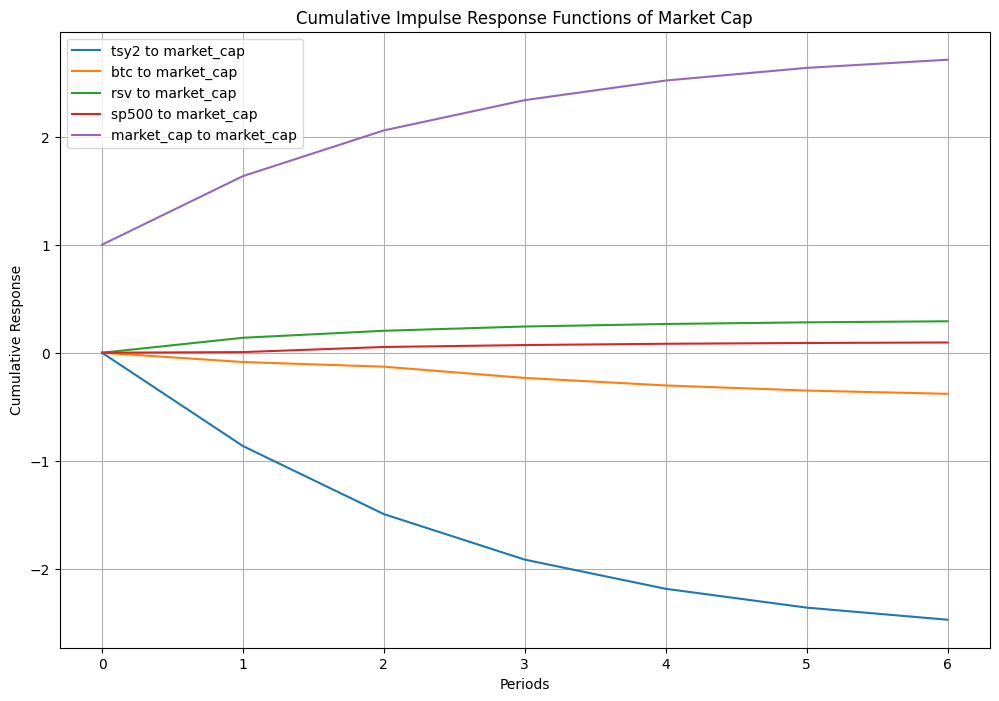

In [295]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR

# Assuming `model_fitted` is your fitted VAR model
irf = model_fitted.irf(6)

# Extract IRFs for the 'market_cap' variable only
irf_market_cap = irf.irfs[:, :, model_fitted.names.index('market_cap')]

# Calculate the cumulative sum
cumulative_irf_market_cap = np.cumsum(irf_market_cap, axis=0)

# Plot the cumulative IRFs
plt.figure(figsize=(12, 8))

for i, var in enumerate(model_fitted.names):
    plt.plot(cumulative_irf_market_cap[:, i], label=f'{var} to market_cap')

plt.title('Cumulative Impulse Response Functions of Market Cap')
plt.xlabel('Periods')
plt.ylabel('Cumulative Response')
plt.legend()
plt.grid(True)
plt.show()

In [296]:
model_fitted.names

['tsy2', 'btc', 'rsv', 'sp500', 'market_cap']

In [297]:
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 08, Aug, 2024
Time:                     21:42:21
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -23.9510
Nobs:                     41.0000    HQIC:                  -24.7483
Log likelihood:           255.817    FPE:                1.14357e-11
AIC:                     -25.2049    Det(Omega_mle):     5.77687e-12
--------------------------------------------------------------------
Results for equation tsy2
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.140537         0.053314            2.636           0.008
L1.tsy2               0.147855         0.183523            0.806           0.420
L1.btc               -0.199197         0.247158           -0.

# Forecasting
forecast = model_fitted.forecast(combined_data.values[-lag_order:], steps=6)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=combined_data.index[-1], periods=6, freq='M'), columns=combined_data.columns)
print(forecast_df)

In [298]:

# Print forecasted log returns
print("Forecasted Log Returns:")
print(forecast_df)

# Convert log returns to price levels
# Get the last known prices
last_prices = data.iloc[-1]

# Calculate cumulative log returns
cumulative_log_returns = forecast_df.cumsum()

# Convert cumulative log returns to cumulative returns
cumulative_returns = np.exp(cumulative_log_returns)

# Forecasted price levels
forecasted_prices = last_prices.values * cumulative_returns

print('cumulative returns:')
print(cumulative_returns)
# Print forecasted prices
print("Forecasted Prices:")
print(forecasted_prices)


Forecasted Log Returns:
                tsy2       btc       rsv     sp500  market_cap
2024-08-31 -0.714282  0.638236  0.013505 -0.071070    0.021165
2024-09-30 -0.335459  0.928764  0.233363  0.115385    0.042051
2024-10-31 -0.231602  0.384210  0.019759  0.012530    0.109295
2024-11-30 -0.852129  0.269407  0.029696  0.021147    0.128141
2024-12-31 -0.187498  0.008132 -0.025175  0.106022    0.123749
2025-01-31 -0.048672 -0.275910 -0.074059  0.140402    0.144574
cumulative returns:
                tsy2       btc       rsv     sp500  market_cap
2024-08-31  0.489543  1.893138  1.013597  0.931397    1.021391
2024-09-30  0.350028  4.792249  1.280010  1.045313    1.065257
2024-10-31  0.277664  7.037196  1.305553  1.058493    1.188285
2024-11-30  0.118425  9.213012  1.344904  1.081115    1.350739
2024-12-31  0.098178  9.288234  1.311468  1.202033    1.528674
2025-01-31  0.093514  7.048669  1.217852  1.383223    1.766456
Forecasted Prices:
                tsy2            btc          rsv       

In [299]:

# Generate forecasts
forecast_steps = 6
forecast = model_fitted.forecast(combined_data.values[-lag_order:], steps=forecast_steps)

# Get the forecast errors and calculate the standard error
forecast_error = model_fitted.forecast_cov(steps=forecast_steps)
standard_errors = np.sqrt(np.diagonal(forecast_error, axis1=1, axis2=2))

# Create DataFrame for forecasted log returns
forecast_dates = pd.date_range(start=combined_data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=combined_data.columns)

# Calculate the confidence intervals in log returns
lower_bound = forecast - 1.28 * standard_errors
upper_bound = forecast + 1.28 * standard_errors
lower_bound_df = pd.DataFrame(lower_bound, index=forecast_dates, columns=combined_data.columns)
upper_bound_df = pd.DataFrame(upper_bound, index=forecast_dates, columns=combined_data.columns)

# Convert log returns to price levels
# Get the last known prices
last_prices = data.iloc[-1]

# Calculate cumulative log returns for forecast and bounds
cumulative_log_returns = forecast_df.cumsum()
cumulative_log_lower = lower_bound_df.cumsum()
cumulative_log_upper = upper_bound_df.cumsum()

# Convert cumulative log returns to cumulative returns
cumulative_returns = np.exp(cumulative_log_returns)
cumulative_returns_lower = np.exp(cumulative_log_lower)
cumulative_returns_upper = np.exp(cumulative_log_upper)

# Forecasted price levels
forecasted_prices_df = last_prices * cumulative_returns
forecasted_prices_lower_df = last_prices * cumulative_returns_lower
forecasted_prices_upper_df = last_prices * cumulative_returns_upper


In [300]:
cumulative_returns

,tsy2,btc,rsv,sp500,market_cap
2024-08-31,1.124636,1.016711,1.005205,1.015314,1.017660
2024-09-30,1.300934,1.017325,0.999570,1.022725,1.036039
2024-10-31,1.508208,1.021449,0.996610,1.029459,1.052336
2024-11-30,1.751835,1.029092,0.993226,1.036861,1.067860
2024-12-31,2.035938,1.036704,0.989948,1.044162,1.083046
2025-01-31,2.367346,1.044686,0.986609,1.051543,1.098087


In [301]:
cumulative_returns_lower

,tsy2,btc,rsv,sp500,market_cap
2024-08-31,0.828233,0.806463,0.943203,0.957602,0.964149
2024-09-30,0.697658,0.631950,0.874799,0.906724,0.919838
2024-10-31,0.587739,0.496539,0.813185,0.857832,0.871761
2024-11-30,0.495663,0.391396,0.755552,0.812040,0.823992
2024-12-31,0.418099,0.308480,0.702062,0.768576,0.777891
2025-01-31,0.352806,0.243199,0.652308,0.727457,0.733916


In [302]:
cumulative_returns_upper

,tsy2,btc,rsv,sp500,market_cap
2024-08-31,1.527115,1.281771,1.071282,1.076504,1.074142
2024-09-30,2.425875,1.637708,1.142136,1.153566,1.166920
2024-10-31,3.870241,2.101260,1.221409,1.235424,1.270315
2024-11-30,6.191556,2.705776,1.305665,1.323926,1.383903
2024-12-31,9.914018,3.484034,1.395884,1.418564,1.507909
2025-01-31,15.884988,4.487551,1.492235,1.520011,1.642960


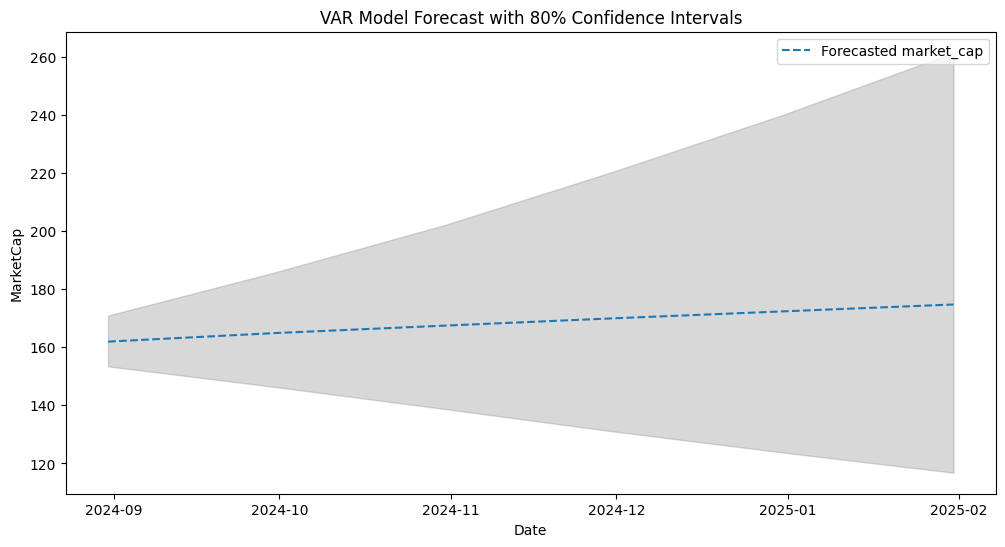

In [303]:

# Plot the forecasted prices with confidence intervals
plt.figure(figsize=(12, 6))
for col in ['market_cap']:
    plt.plot(forecasted_prices_df.index, forecasted_prices_df[col], label=f'Forecasted {col}', linestyle='--')
    plt.fill_between(forecasted_prices_df.index, forecasted_prices_lower_df[col], forecasted_prices_upper_df[col], color='gray', alpha=0.3)

plt.legend()
plt.title('VAR Model Forecast with 80% Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('MarketCap')
plt.show()

In [308]:
log_returns=combined_data.copy()
# Assuming log_returns is your DataFrame
# Create lagged variables for btc, rsv, tsy2, and sp500
log_returns['L_btc'] = log_returns['btc'].shift(1)
log_returns['L_rsv'] = log_returns['rsv'].shift(1)
log_returns['L_tsy2'] = log_returns['tsy2'].shift(1)
# log_returns['L_dollar'] = log_returns['dollar'].shift(1)
log_returns['L_sp500'] = log_returns['sp500'].shift(1)
log_returns['L_market_cap'] = log_returns['market_cap'].shift(1)


# Drop rows with NaN values
log_returns = log_returns.dropna()

# Fit the regression model
models = []
models.append(ols('market_cap ~ L_btc + L_rsv  + L_sp500+L_market_cap', data=log_returns).fit())

# Use Stargazer to display the results
sg = Stargazer(models)
sg

In [310]:
log_returns=combined_data.copy()
# Assuming log_returns is your DataFrame
# Create lagged variables for btc, rsv, tsy2, and sp500
log_returns['L_btc'] = log_returns['btc'].shift(1)
log_returns['L_rsv'] = log_returns['rsv'].shift(1)
# log_returns['L_tsy2'] = log_returns['tsy2'].shift(1)
log_returns['L_sp500'] = log_returns['sp500'].shift(1)
log_returns['L_market_cap'] = log_returns['market_cap'].shift(1)


# Drop rows with NaN values
log_returns = log_returns.dropna()

# Fit the regression model
models = []
models.append(ols('market_cap ~ btc + rsv  + sp500+tsy2', data=log_returns).fit())

# Use Stargazer to display the results
sg = Stargazer(models)
sg

In [87]:
log_returns

,btc,rsv,tsy2,sp500,market_cap
2019-02-28,0.100218,0.014248,-0.007968,0.040686,-0.033838
2019-03-31,0.057928,-0.011320,-0.118784,0.004641,-0.000429
2019-04-30,0.301223,-0.074755,0.044060,0.042528,0.299679
2019-05-31,0.464644,0.025758,-0.104403,-0.050527,0.099229
2019-06-30,0.398650,-0.026219,-0.166185,0.045915,0.122273
...,...,...,...,...,...
2024-03-31,0.104650,-0.020226,-0.021787,0.034647,0.063479
2024-04-30,-0.077507,-0.050376,0.074265,-0.034278,0.063072
2024-05-31,0.051237,0.025241,0.014213,0.037789,-0.002830
2024-06-30,-0.105720,-0.031795,-0.051718,0.039270,0.003309


/Users/gordonliao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


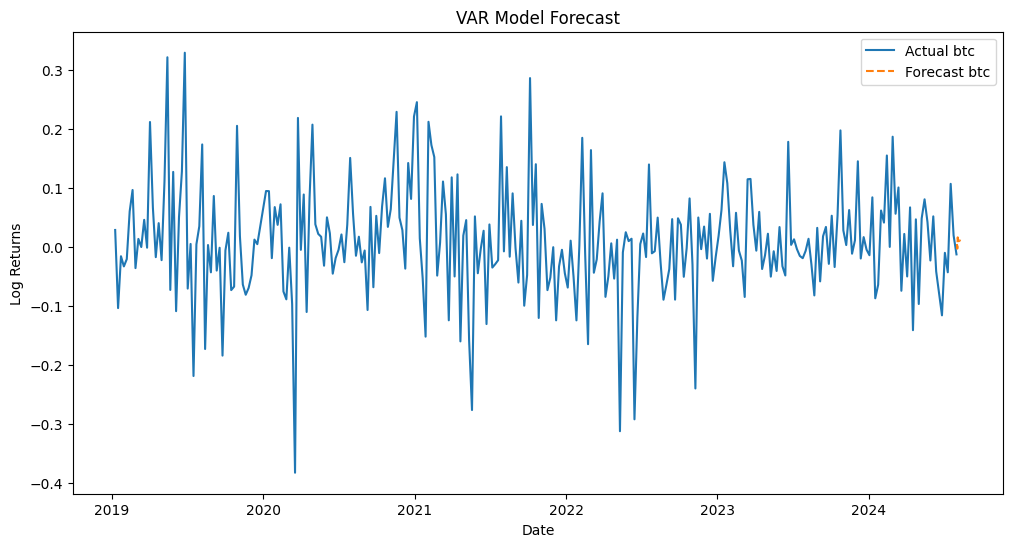

In [43]:
# Plot the forecasts
plt.figure(figsize=(12, 6))
for col in ['btc']:
    plt.plot(log_returns.index, log_returns[col], label=f'Actual {col}')
    plt.plot(forecast_df.index, forecast_df[col], label=f'Forecast {col}', linestyle='--')

plt.legend()
plt.title('VAR Model Forecast')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.show()

In [42]:
log_returns.columns

Index(['btc', 'rsv', 'tsy2', 'sp500'], dtype='object')